In [1]:
import os

from dotenv import load_dotenv

from dynamic_pricing.core.db_utils import get_db_connection, load_order_data
import pandas as pd
import matplotlib.pyplot as plt
import itertools


load_dotenv()
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option("future.no_silent_downcasting", True)

### Establish database connection

In [ ]:
conn = get_db_connection()

df: pd.DataFrame = load_order_data(conn, os.getenv("PARTNER1"))
print(df.info)

In [3]:
print(df.columns)
df.head()
df.fillna(0, inplace=True)

Index(['order_id', 'platform_order_id', 'platform_order_number',
       'order_status', 'order_placed_timestamp', 'order_updated_timestamp',
       'order_prepare_for_timestamp', 'order_start_prepping_at_timestamp',
       'customer_id', 'first_name', 'contact_number', 'contact_access_code',
       'partner_id', 'partner_name', 'item_id', 'platform_item_id',
       'item_name', 'item_operational_name', 'item_fractional_cost',
       'item_quantity', 'item_fractional_price', 'modifier_id',
       'platform_modifier_id', 'modifier_name', 'modifier_operational_name',
       'modifier_quantity', 'modifier_fractional_price'],
      dtype='object')


Filter to keep only the items we are analyzing

In [4]:
pre_dp_df = df[df["item_operational_name"].str.contains("Wrap")]
pre_dp_df = pre_dp_df[
    (pre_dp_df["order_placed_timestamp"] >= "2023-06-26")
    & (pre_dp_df["order_placed_timestamp"] < "2023-7-17")
]
pre_dp_df.info()


post_dp_df = df[df["item_operational_name"].str.contains("Wrap")]
post_dp_df = post_dp_df[
    (post_dp_df["order_placed_timestamp"] >= "2023-7-17")
    & (post_dp_df["order_placed_timestamp"] < "2023-8-07")
]
post_dp_df.info()

interval = 60

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 0 to 234
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           64 non-null     int64         
 1   platform_order_id                  64 non-null     object        
 2   platform_order_number              64 non-null     int64         
 3   order_status                       64 non-null     object        
 4   order_placed_timestamp             64 non-null     datetime64[ns]
 5   order_updated_timestamp            64 non-null     datetime64[ns]
 6   order_prepare_for_timestamp        64 non-null     datetime64[ns]
 7   order_start_prepping_at_timestamp  64 non-null     datetime64[ns]
 8   customer_id                        64 non-null     object        
 9   first_name                         64 non-null     object        
 10  contact_number                     64 non-nu

In [5]:
from dynamic_pricing.analysis.metrics import split_weekdays_and_weekends

pre_dp_df_weekdays, pre_dp_df_weekends = split_weekdays_and_weekends(
    pre_dp_df, "order_placed_timestamp"
)
post_dp_df_weekdays, post_dp_df_weekends = split_weekdays_and_weekends(
    post_dp_df, "order_placed_timestamp"
)

### Data analysis of core demand and supply metrics
The four images generated after each sell represent pre-dp weekday, pre-dp weekend, post-dp weekday, and post-dp weekend plots

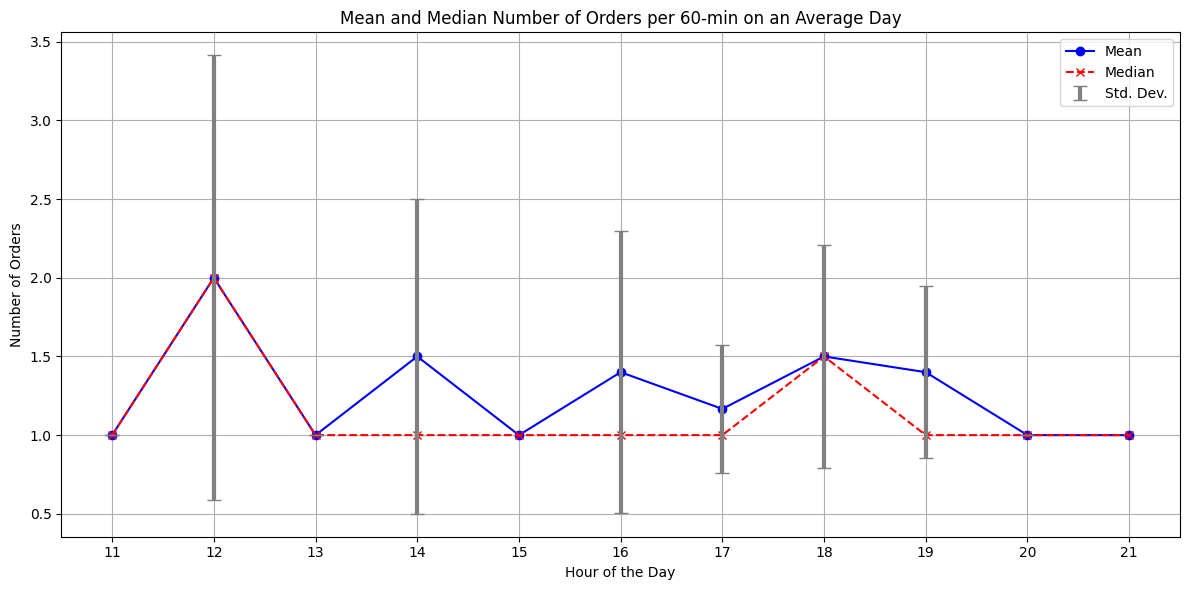

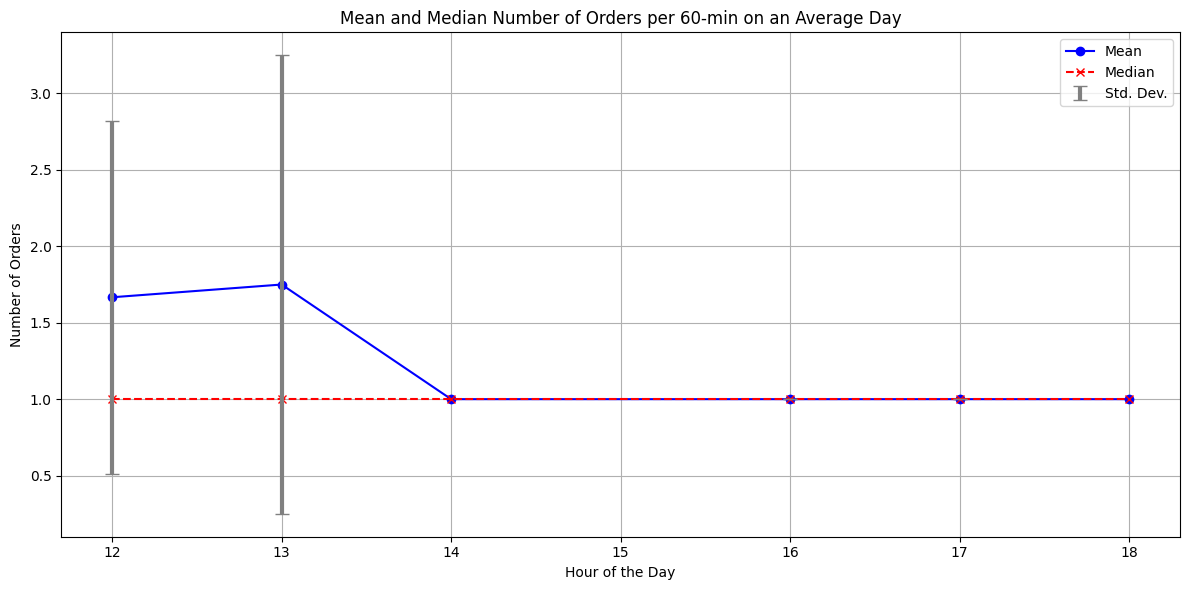

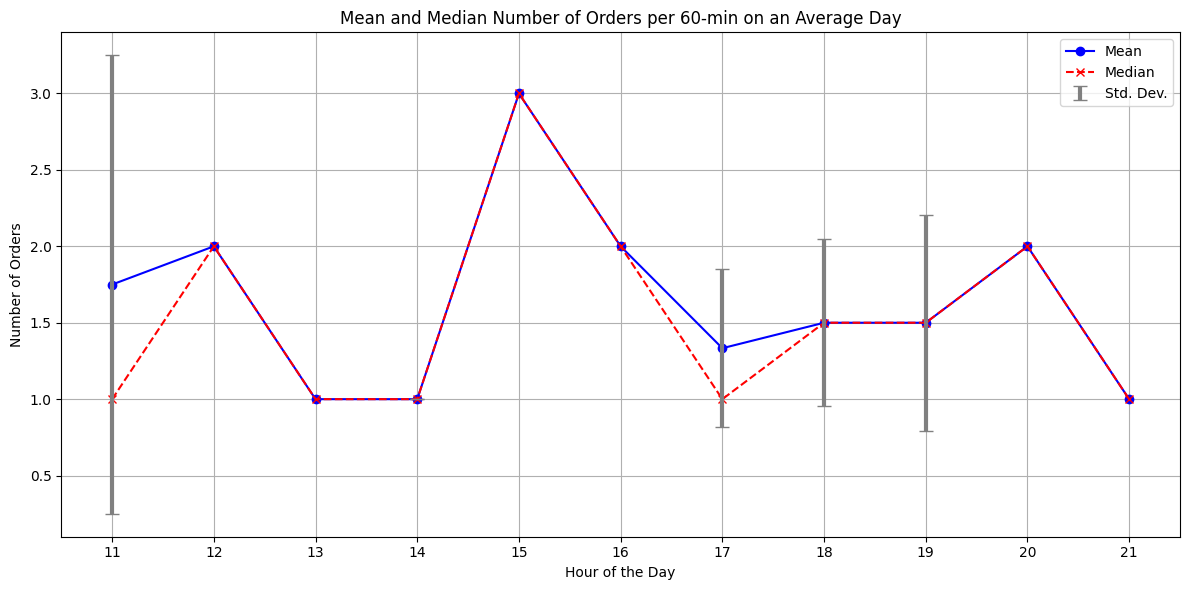

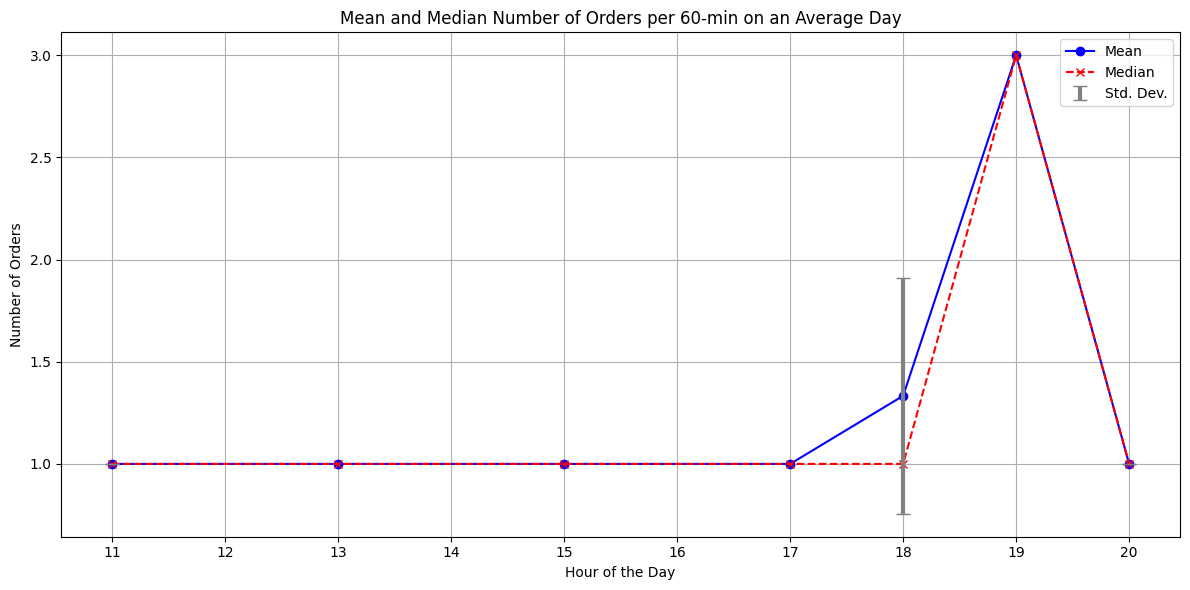

In [6]:
from dynamic_pricing.analysis.metrics import calculate_average_orders_per_interval

calculate_average_orders_per_interval(pre_dp_df_weekdays, interval=interval,plot=True)
calculate_average_orders_per_interval(pre_dp_df_weekends, interval=interval, plot=True)

calculate_average_orders_per_interval(
    post_dp_df_weekdays, interval=interval, plot=True
)
calculate_average_orders_per_interval(
    post_dp_df_weekends, interval=interval, plot=True
)

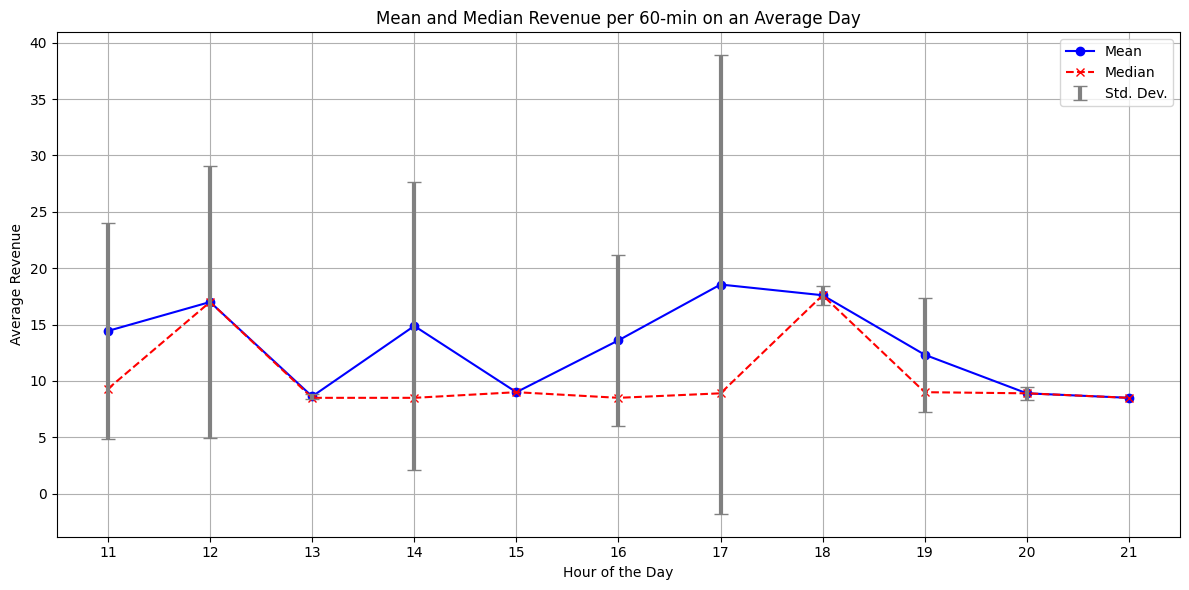

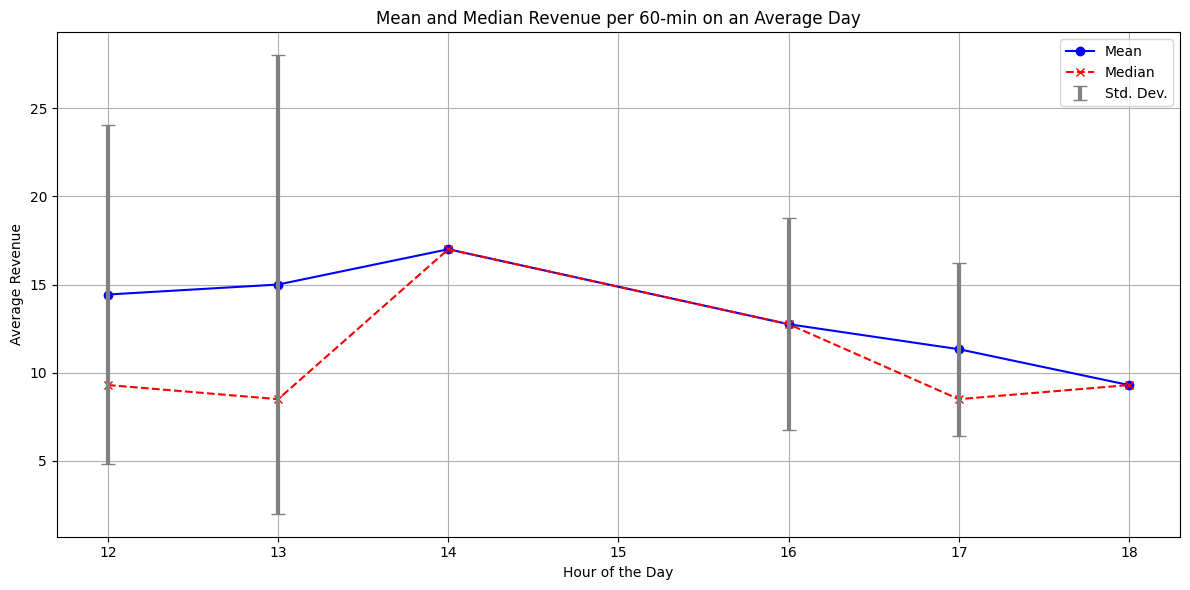

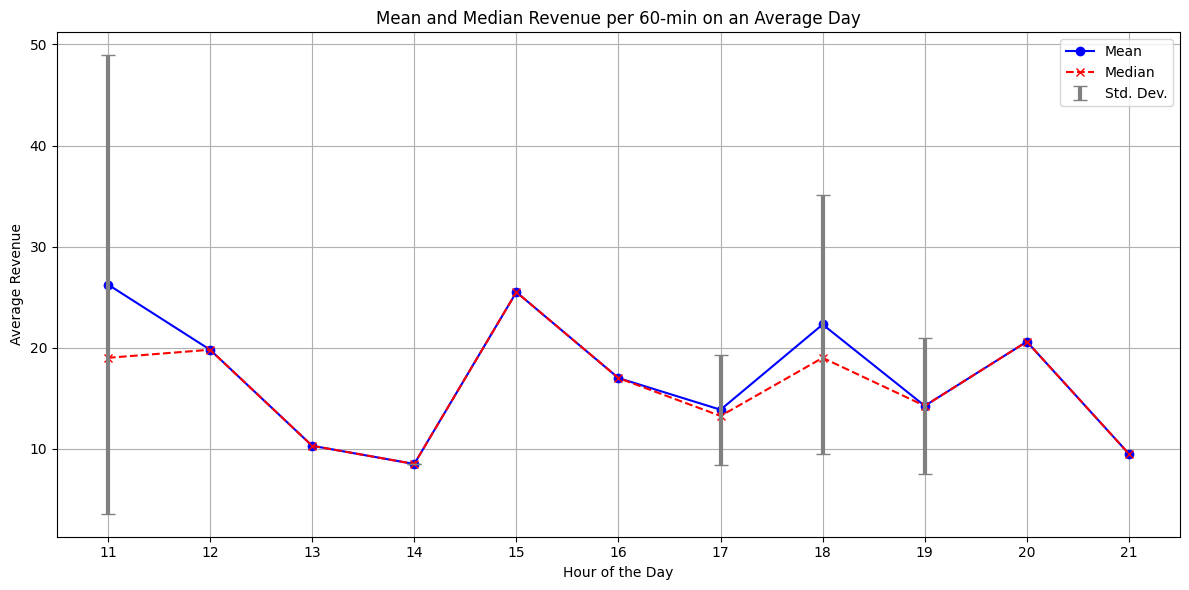

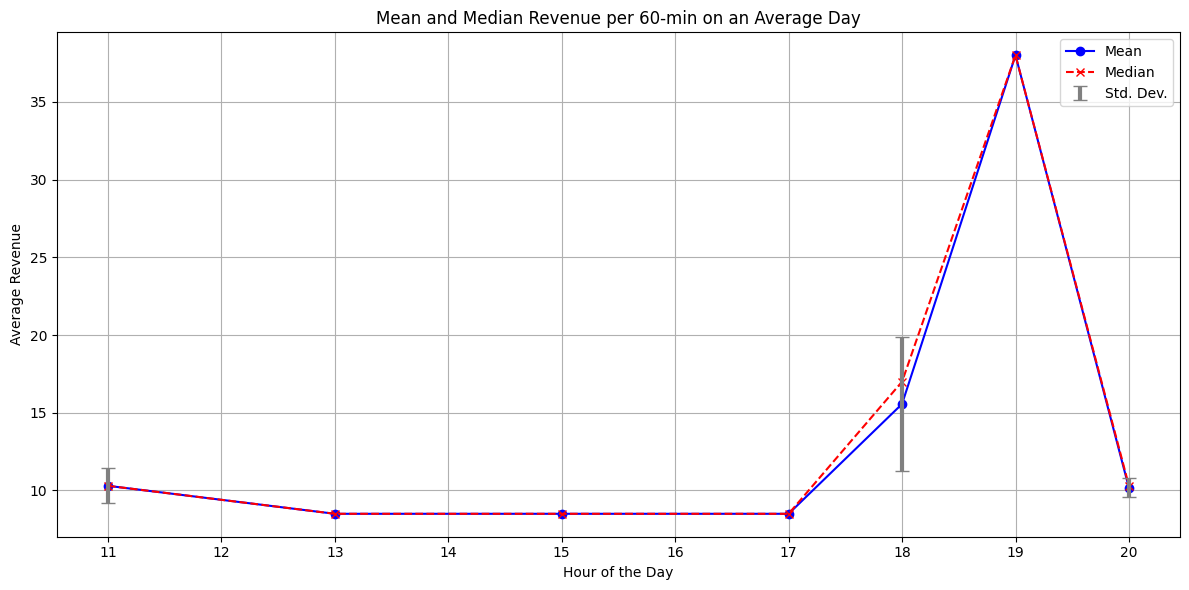

In [7]:
from dynamic_pricing.analysis.metrics import calculate_average_revenue_per_interval

calculate_average_revenue_per_interval(pre_dp_df_weekdays, interval, plot=True)
calculate_average_revenue_per_interval(pre_dp_df_weekends, interval, plot=True)

calculate_average_revenue_per_interval(post_dp_df_weekdays, interval, plot=True)
calculate_average_revenue_per_interval(post_dp_df_weekends, interval, plot=True)

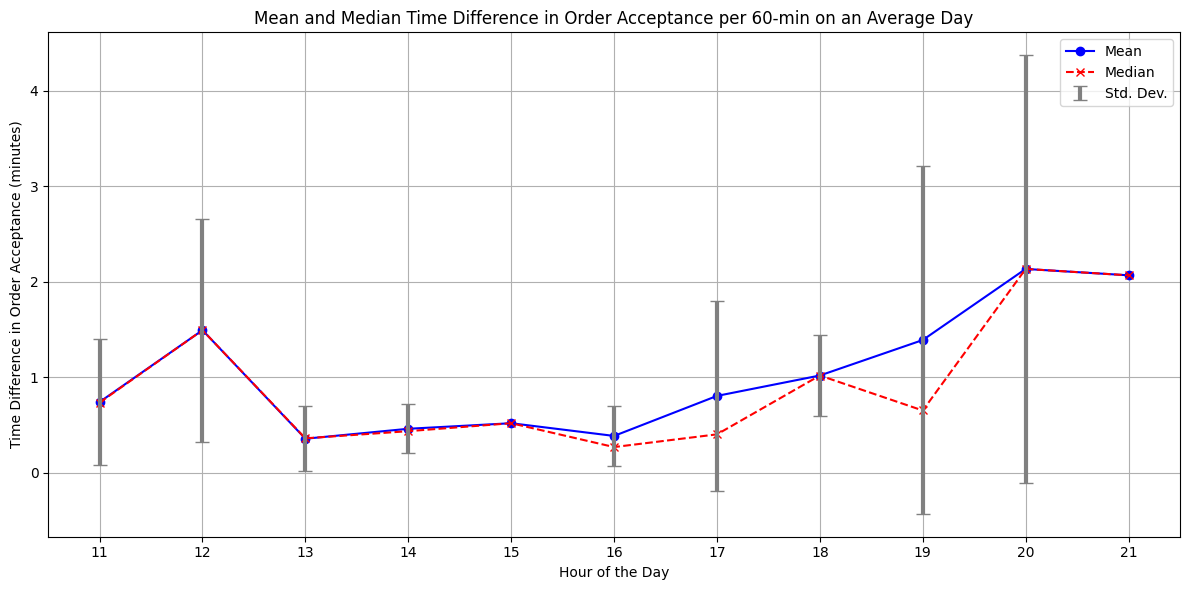

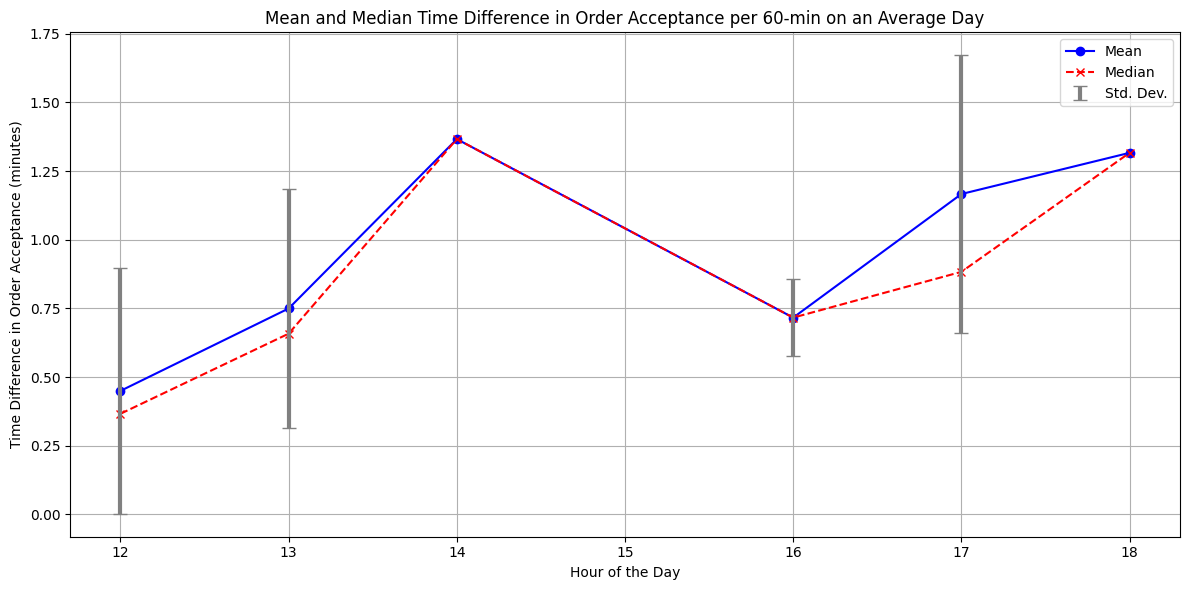

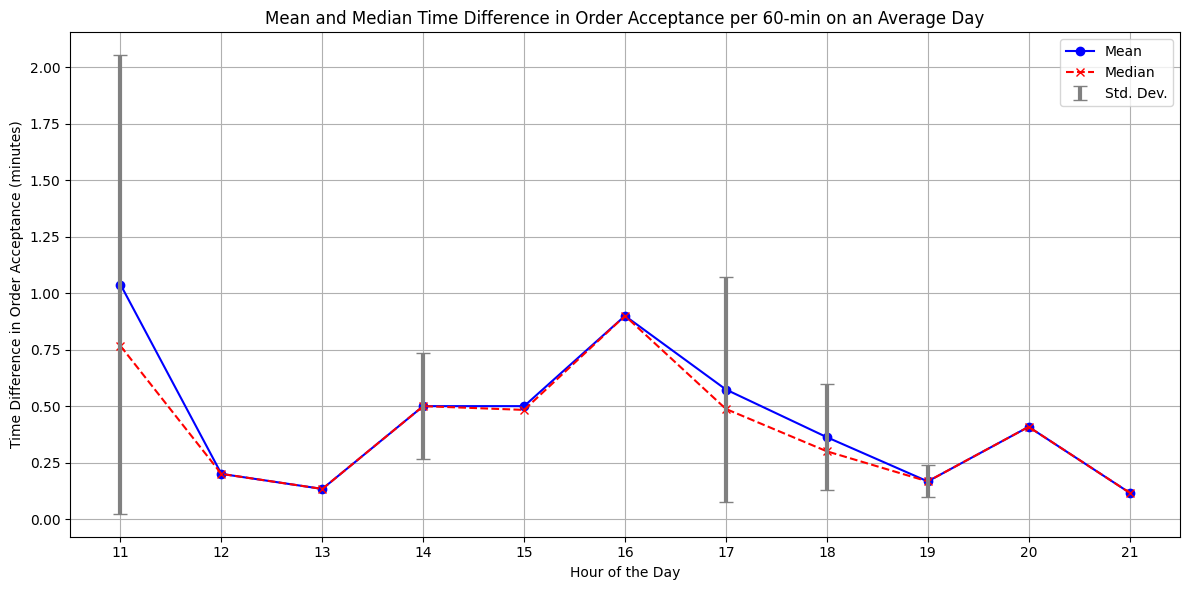

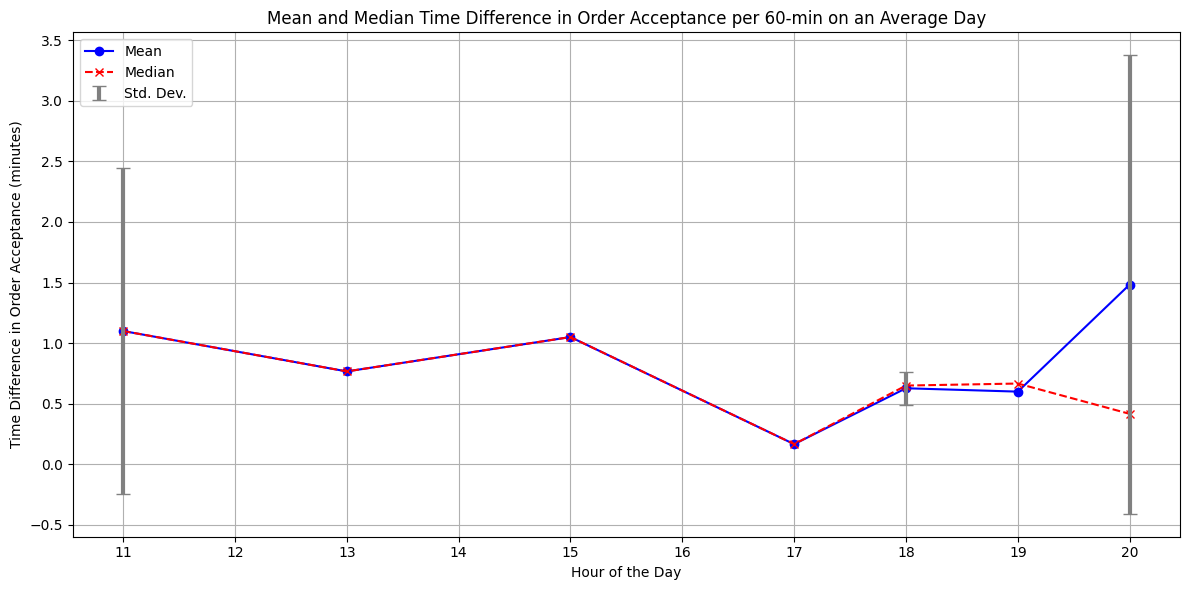

In [8]:
from dynamic_pricing.analysis.metrics import (
    calculate_time_difference_in_order_acceptance_per_interval,
)

calculate_time_difference_in_order_acceptance_per_interval(
    pre_dp_df_weekdays, interval, plot=True
)
calculate_time_difference_in_order_acceptance_per_interval(
    pre_dp_df_weekends, interval, plot=True
)

calculate_time_difference_in_order_acceptance_per_interval(
    post_dp_df_weekdays, interval, plot=True
)
calculate_time_difference_in_order_acceptance_per_interval(
    post_dp_df_weekends, interval, plot=True
)

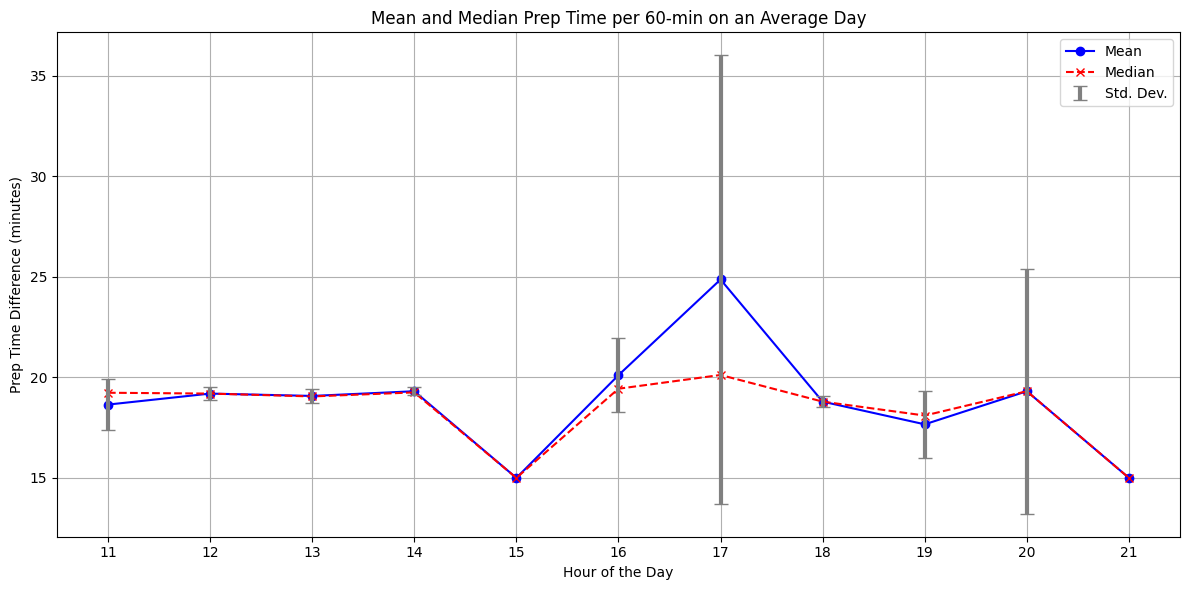

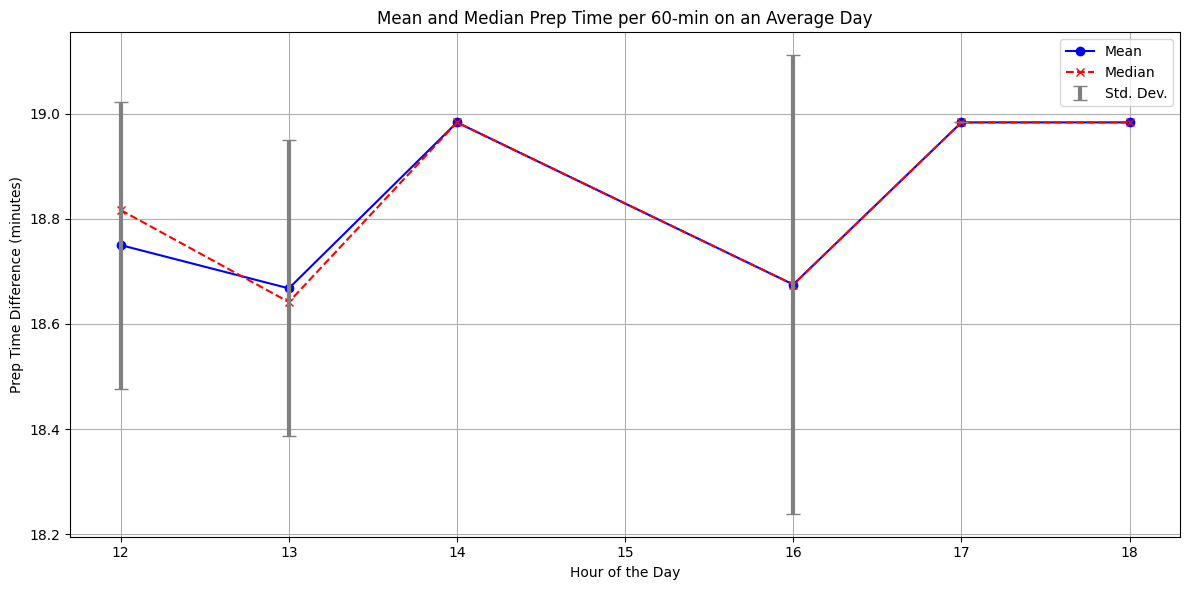

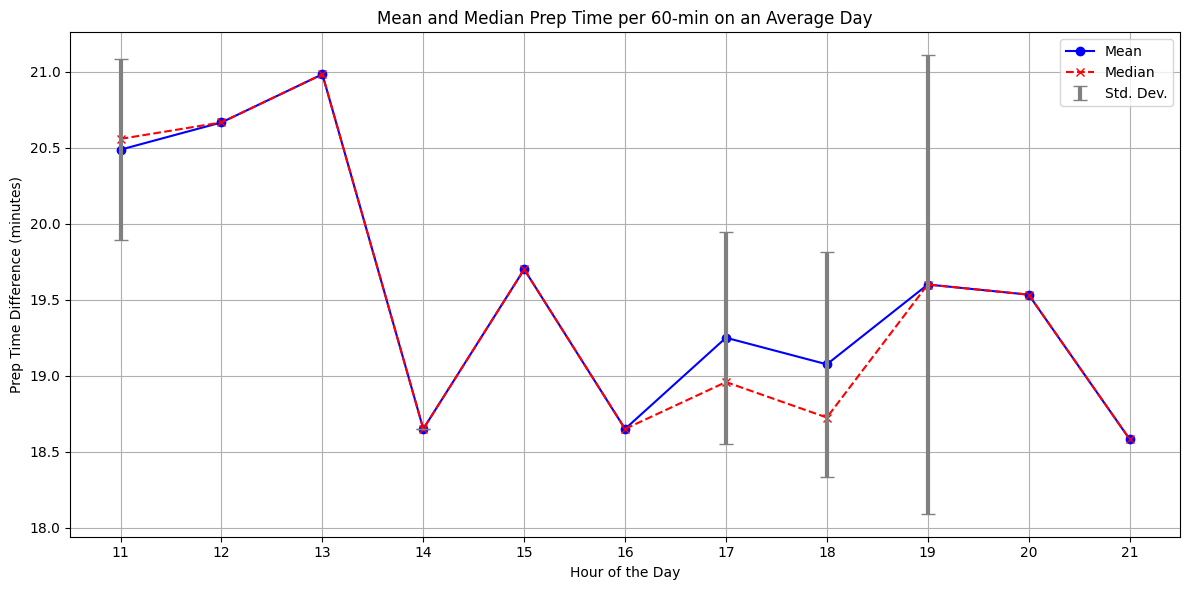

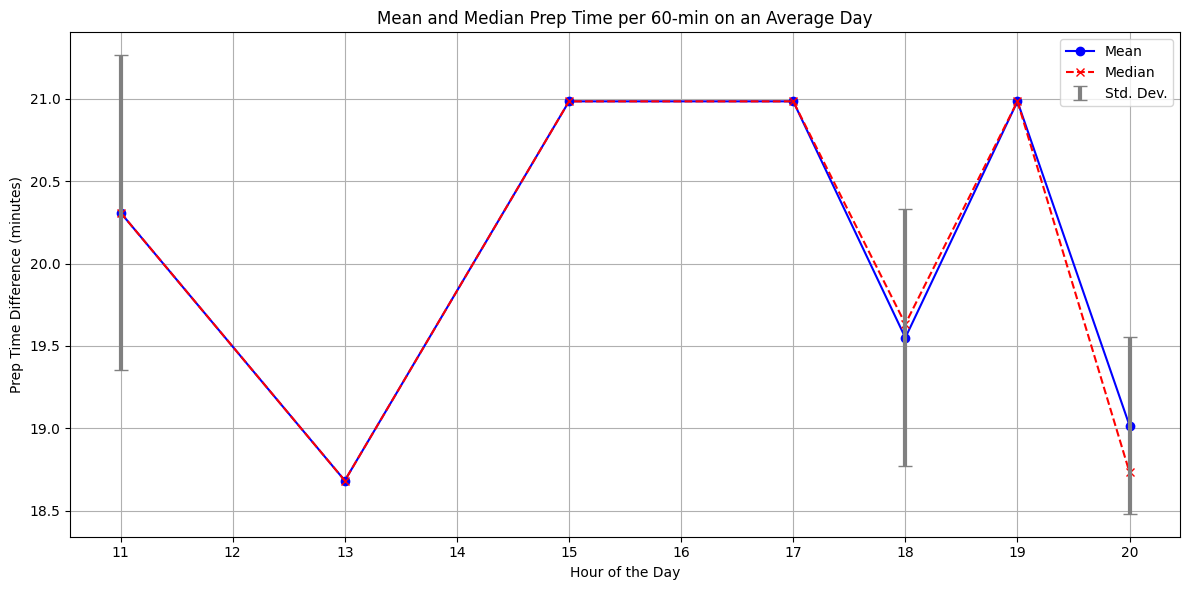

In [9]:
from dynamic_pricing.analysis.metrics import calculate_prep_time_per_interval

calculate_prep_time_per_interval(pre_dp_df_weekdays, interval, plot=True)
calculate_prep_time_per_interval(pre_dp_df_weekends, interval, plot=True)

calculate_prep_time_per_interval(post_dp_df_weekdays, interval, plot=True)
calculate_prep_time_per_interval(post_dp_df_weekends, interval, plot=True)

### Additional analytics

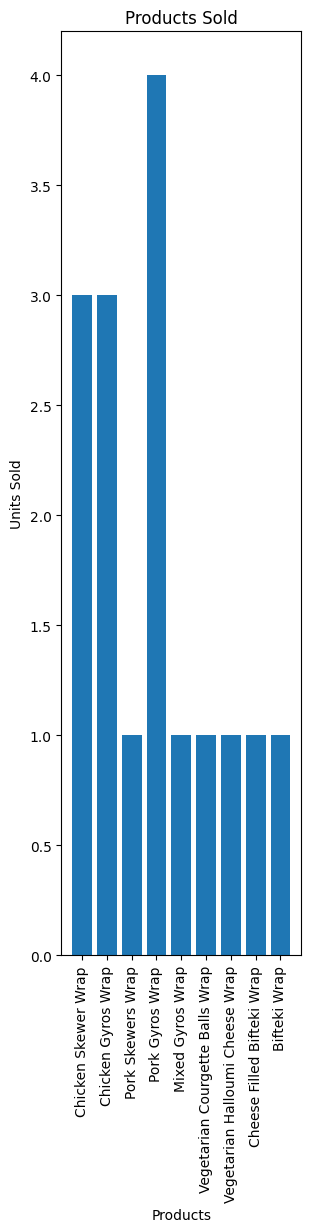

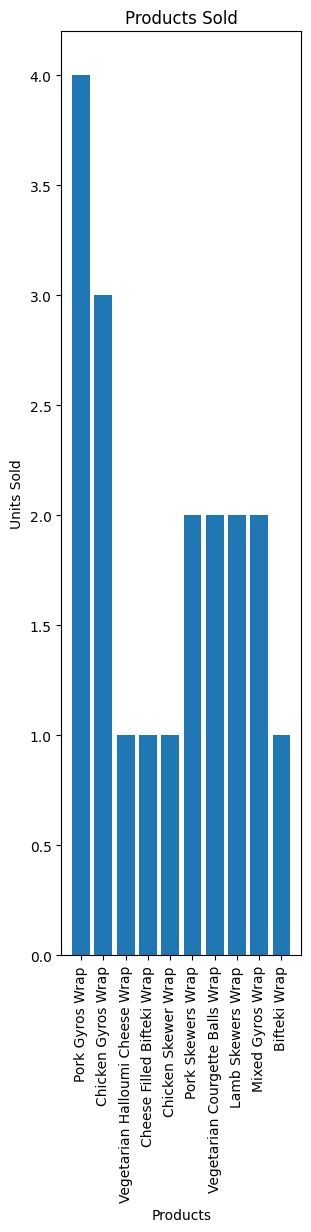

In [10]:
from dynamic_pricing.analysis.metrics import calculate_items_sold
calculate_items_sold(pre_dp_df, plot=True)
calculate_items_sold(post_dp_df, plot=True)

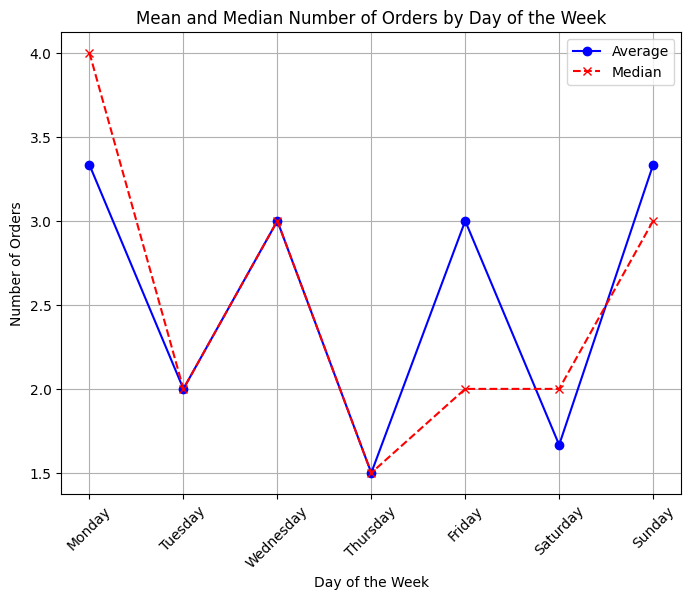

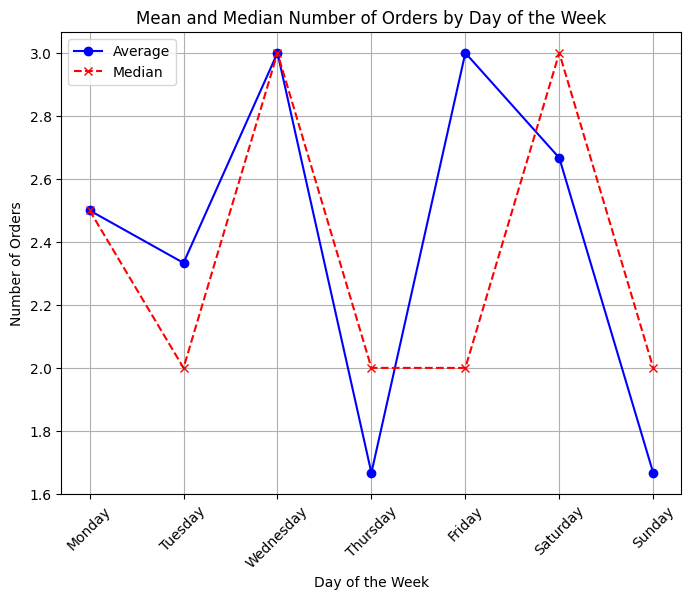

In [11]:
from dynamic_pricing.analysis.metrics import calculate_average_orders_by_day_of_week

calculate_average_orders_by_day_of_week(pre_dp_df, plot=True)
calculate_average_orders_by_day_of_week(post_dp_df, plot=True)

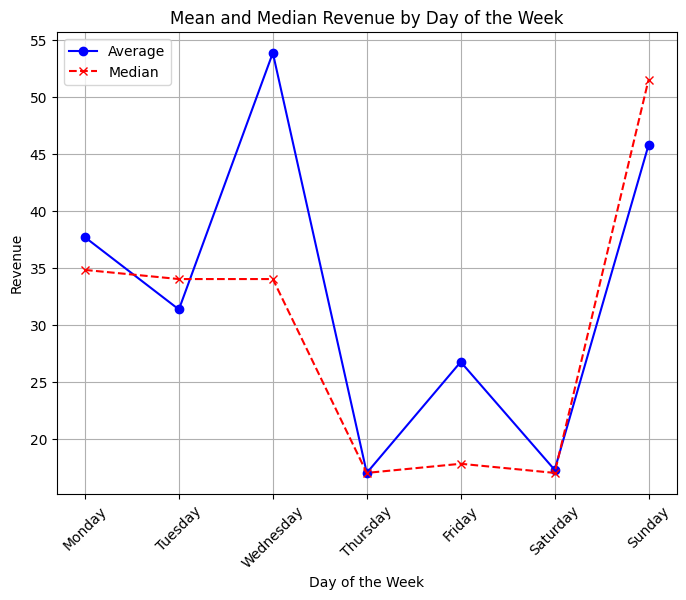

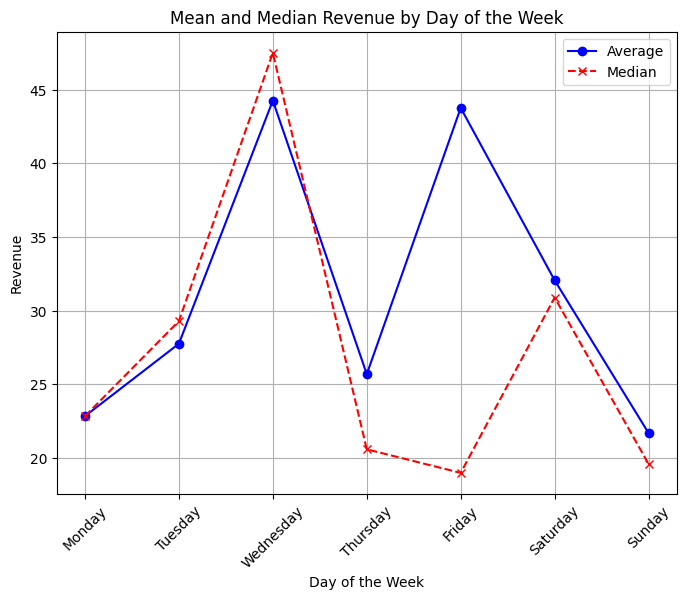

In [12]:
from dynamic_pricing.analysis.metrics import calculate_average_revenue_by_day_of_week

calculate_average_revenue_by_day_of_week(pre_dp_df, plot=True)
calculate_average_revenue_by_day_of_week(post_dp_df, plot=True)

Manage outliers

In [13]:
from dynamic_pricing.analysis.metrics import calculate_revenue

revenue_df = calculate_revenue(pre_dp_df)
revenue_df["revenue"] = pd.to_numeric(revenue_df["revenue"], errors="coerce")
largest_series = revenue_df["revenue"].nlargest(5).reset_index(drop=True)
print(largest_series)
difference_amount = largest_series[1]-largest_series[2]
print(difference_amount)
revenue_df[revenue_df["revenue"] == largest_series[1]] #the outlier was on a wednesday at 5.26pm

0    59.5
1    59.5
2    34.0
3    34.0
4    34.0
Name: revenue, dtype: float64
25.5


,order_id,item_quantity,item_fractional_price,modifier_fractional_price,modifier_quantity,order_placed_timestamp,order_value,revenue
116,98,3,850,0,0,2023-07-05 17:26:42,25.5,59.5
118,98,4,850,0,0,2023-07-05 17:26:42,34.0,59.5


In [14]:
from dynamic_pricing.analysis.metrics import calculate_revenue_by_day_period

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
pre_dp_df_weekday_revenue = calculate_revenue_by_day_period(
    pre_dp_df_weekdays, time_intervals=time_intervals
)

pre_dp_df_weekend_revenue = calculate_revenue_by_day_period(
    pre_dp_df_weekends, time_intervals=time_intervals
)
post_dp_df_weekday_revenue = calculate_revenue_by_day_period(
    post_dp_df_weekdays, time_intervals=time_intervals
)
post_dp_df_weekend_revenue = calculate_revenue_by_day_period(
    post_dp_df_weekends, time_intervals=time_intervals
)

# remove outlier
pre_dp_df_weekday_revenue["14:00:00 to 18:45:00"] = pre_dp_df_weekday_revenue[
    "14:00:00 to 18:45:00"
] - difference_amount df.groupby("interval_label").size()

print(pre_dp_df_weekday_revenue, pre_dp_df_weekday_revenue.sum())
print(pre_dp_df_weekend_revenue, pre_dp_df_weekend_revenue.sum())
print(post_dp_df_weekday_revenue, post_dp_df_weekday_revenue.sum())
print(post_dp_df_weekend_revenue, post_dp_df_weekend_revenue.sum())

interval_label
00:00:00 to 14:00:00    111.8
14:00:00 to 18:45:00    257.5
18:45:00 to 23:59:59     87.9
Name: order_value, dtype: object 457.20000000000005
interval_label
00:00:00 to 14:00:00    103.3
14:00:00 to 18:45:00     85.8
18:45:00 to 23:59:59        0
Name: order_value, dtype: object 189.1
interval_label
00:00:00 to 14:00:00    135.1
14:00:00 to 18:45:00    248.0
18:45:00 to 23:59:59     87.1
Name: order_value, dtype: object 470.20000000000005
interval_label
00:00:00 to 14:00:00    29.1
14:00:00 to 18:45:00    34.0
18:45:00 to 23:59:59    98.2
Name: order_value, dtype: object 161.3


In [15]:
from dynamic_pricing.analysis.metrics import calculate_profit_by_day_period

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
pre_dp_df_weekday_profit= calculate_profit_by_day_period(
    pre_dp_df_weekdays, time_intervals=time_intervals
)

pre_dp_df_weekend_profit = calculate_profit_by_day_period(
    pre_dp_df_weekends, time_intervals=time_intervals
)
post_dp_df_weekday_profit = calculate_profit_by_day_period(
    post_dp_df_weekdays, time_intervals=time_intervals
)
post_dp_df_weekend_profit = calculate_profit_by_day_period(
    post_dp_df_weekends, time_intervals=time_intervals
)

# remove outlier
pre_dp_df_weekday_profit.loc["14:00:00 to 18:45:00"] -= difference_amount

print(pre_dp_df_weekday_profit, pre_dp_df_weekday_profit.sum())
print(pre_dp_df_weekend_profit, pre_dp_df_weekend_profit.sum())
print(post_dp_df_weekday_profit, post_dp_df_weekday_profit.sum())
print(post_dp_df_weekend_profit, post_dp_df_weekend_profit.sum())

interval_label
00:00:00 to 14:00:00     89.8
14:00:00 to 18:45:00    209.5
18:45:00 to 23:59:59     67.9
Name: profit, dtype: object 367.20000000000005
interval_label
00:00:00 to 14:00:00    79.3
14:00:00 to 18:45:00    71.8
18:45:00 to 23:59:59       0
Name: profit, dtype: object 151.1
interval_label
00:00:00 to 14:00:00    115.1
14:00:00 to 18:45:00    203.5
18:45:00 to 23:59:59     71.1
Name: profit, dtype: object 389.70000000000005
interval_label
00:00:00 to 14:00:00    23.1
14:00:00 to 18:45:00    26.0
18:45:00 to 23:59:59    82.2
Name: profit, dtype: object 131.3


In [16]:
from dynamic_pricing.analysis.metrics import calculate_orders_by_day_period

print(calculate_orders_by_day_period(pre_dp_df_weekdays, time_intervals))
print(calculate_orders_by_day_period(pre_dp_df_weekends, time_intervals))
print(calculate_orders_by_day_period(post_dp_df_weekdays, time_intervals))
print(calculate_orders_by_day_period(post_dp_df_weekends, time_intervals))

         interval_label  order_count
0  00:00:00 to 14:00:00           11
1  14:00:00 to 18:45:00           24
2  18:45:00 to 23:59:59           10
         interval_label  order_count
0  00:00:00 to 14:00:00           12
1  14:00:00 to 18:45:00            7
2  18:45:00 to 23:59:59            0
         interval_label  order_count
0  00:00:00 to 14:00:00           10
1  14:00:00 to 18:45:00           22
2  18:45:00 to 23:59:59            8
         interval_label  order_count
0  00:00:00 to 14:00:00            3
1  14:00:00 to 18:45:00            4
2  18:45:00 to 23:59:59            8
